In [24]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math

In [68]:
# === 1. Load and pre-process data ===

def preprocess_data(df):
    df = df[['time', 'ask price', 'ask volume', 'bid price', 'bid volume']].copy()

    # Find idx of max bid price and min ask price within each time group
    idx_max_bid = df.groupby('time')['bid price'].idxmax()
    idx_min_ask = df.groupby('time')['ask price'].idxmin()

    # Select rows corresponding to max bid and min ask
    bids = df.loc[idx_max_bid, ['time', 'bid price', 'bid volume']]
    asks = df.loc[idx_min_ask, ['time', 'ask price', 'ask volume']]

    # Merge bids and asks on time
    merged = pd.merge(bids, asks, on='time', how='outer').sort_index()

    # Recompute mid price and spread
    merged['mid price'] = (merged['ask price'] + merged['bid price']) / 2
    merged['spread'] = merged['ask price'] - merged['bid price']

    return merged


symbols = ['AAPL','AMZN','GOOG','INTC','MSFT']
dataframes = {}

for sym in symbols:
    df = pd.read_csv(sym + "_backtest_data.csv")
    df.drop_duplicates(inplace=True)
    df = preprocess_data(df)
    df.columns = ['time', 'bid price', 'bid volume', 'ask price', 'ask volume',
       'mid price', 'spread']
    df['timestamp'] = pd.to_datetime(df['time'],unit='s',origin='unix')
    df = df.set_index('timestamp').sort_index()
    dataframes[sym] = df.copy()

tick_size = 0.01
updates_back = 50

In [69]:
def compute_ofi_simple(bid_v, ask_v):
    return bid_v.diff().fillna(0) - ask_v.diff().fillna(0)

def add_features(df):
    df = df.copy()
    df['spread_ticks'] = (df['ask price'] - df['bid price'])/tick_size
    df['ofi'] = compute_ofi_simple(df['bid volume'], df['ask volume']).rolling(window=updates_back, min_periods=1).sum()
    df['mid']   = (df['ask price'] + df['bid price'])/2
    df['mom']   = np.log(df['mid']).diff(updates_back)
    df['vol_t'] = df['mid'].rolling('30s').std().fillna(method='bfill')

    mins = df.index.floor('T')
    secs = (df.index - mins).total_seconds()
    df['tau'] = secs/60.0
    return df

def add_features_and_normalize(df):
    df = add_features(df)
    cols = ['ofi','mom','spread_ticks','tau', 'vol_t','spread']
    means = df[cols].mean()
    stds  = df[cols].std()
    for c in cols:
        df[c+'_z'] = (df[c] - means[c]) / stds[c]
    return df

def enhanced_features(df):
    df = df.copy()
    df['micro_price'] = (df['bid price']*df['ask volume'] + df['ask price']*df['bid volume']) / \
                       (df['bid volume'] + df['ask volume'])
    df['vol_imb'] = (df['bid volume'] - df['ask volume']) / (df['bid volume'] + df['ask volume'])
    df['total_volume'] = df['bid volume'] + df['ask volume']

    # Proper VWAP calculation
    df['cum_price_volume'] = (df['ask price']*df['ask volume'] + df['bid price']*df['bid volume']).cumsum()
    df['cum_volume'] = (df['ask volume'] + df['bid volume']).cumsum()
    df['vwap'] = df['cum_price_volume'] / df['cum_volume']

    # Proper Price Velocity calculation (5-period difference of mid price)
    df['price_velocity'] = df['mid'].diff(5)  # NEW: This is the key fix

    # Lagged prices for autocorrelation
    for lag in [1, 2, 4]:
        df[f'price_lag_{lag}'] = df['mid'].shift(lag)

    # Normalize features
    cols = ['vol_imb','total_volume','price_velocity']
    means = df[cols].mean()
    stds = df[cols].std()
    for c in cols:
        df[c+'_z'] = (df[c] - means[c]) / stds[c]

    return df.dropna()

# === 3. Minute-flags helper ===
def _minute_flags(df):
    mins = df.index.floor('T')
    secs = (df.index - mins).total_seconds()
    return pd.Series(mins, index=df.index), pd.Series(secs, index=df.index)

for sym in symbols:
    dataframes[sym] = add_features_and_normalize(dataframes[sym])
    dataframes[sym] = enhanced_features(dataframes[sym])
    ms, es = _minute_flags(dataframes[sym])
    dataframes[sym]['minute_start'], dataframes[sym]['elapsed'] = ms, es


In [70]:
def exec_event_driven_dual(df, params=[0.5, 0.25, 0]):
    """
    Execute trades based on market events for both 'buy' and 'sell' in one pass.

    Returns:
        dict: {'buy': DataFrame, 'sell': DataFrame}
    """
    df = df.copy()

    # Compute time features if not already present
    if 'minute_start' not in df or 'elapsed' not in df:
        df['minute_start'] = df.index.floor('T')
        df['elapsed'] = (df.index - df['minute_start']).dt.total_seconds()

    # Precompute thresholds
    spread_thresh = df['spread_ticks'].quantile(params[1])
    vol_imb_thresh = params[0]
    mom_thresh = params[2]

    # Initialize result containers
    buy_execs, sell_execs = {}, {}

    grouped = df.groupby('minute_start')
    for m, group in grouped:
        # Default to last row in case of fallback
        fallback_ts = group.index[-1]
        fallback_buy_price = group['ask price'].iloc[-1]
        fallback_sell_price = group['bid price'].iloc[-1]

        # Conditions
        buy_cond_early = (
            (group['elapsed'] < 25) &
            (group['spread_ticks'] <= spread_thresh) &
            (group['vol_imb'] > vol_imb_thresh) &
            (group['price_velocity'] > mom_thresh)
        )
        buy_cond_mid = (
            (group['spread_ticks'] <= spread_thresh) &
            (group['vol_imb'] > vol_imb_thresh)
        )

        sell_cond_early = (
            (group['elapsed'] < 25) &
            (group['spread_ticks'] <= spread_thresh) &
            (group['vol_imb'] < -vol_imb_thresh) &
            (group['price_velocity'] < mom_thresh)
        )
        sell_cond_mid = (
            (group['spread_ticks'] <= spread_thresh) &
            (group['vol_imb'] < -vol_imb_thresh)
        )

        # Execute for buy
        executed = False
        for idx in group.index:
            if buy_cond_early.loc[idx] or buy_cond_mid.loc[idx]:
                buy_execs[idx] = group.at[idx, 'ask price']
                executed = True
                break
        if not executed:
            buy_execs[fallback_ts] = fallback_buy_price

        # Execute for sell
        executed = False
        for idx in group.index:
            if sell_cond_early.loc[idx] or sell_cond_mid.loc[idx]:
                sell_execs[idx] = group.at[idx, 'bid price']
                executed = True
                break
        if not executed:
            sell_execs[fallback_ts] = fallback_sell_price

    return {
        'buy': pd.DataFrame.from_dict(buy_execs, orient='index', columns=['ExecPrice']),
        'sell': pd.DataFrame.from_dict(sell_execs, orient='index', columns=['ExecPrice']),
    }

In [71]:
def exec_micro_price_spread_tiers_dual(df, params=[2, 3, 4, 999], tick_size=0.01):
    """
    Optimized execution strategy for both 'buy' and 'sell' directions.
    """
    df2 = df.copy()
    df2['minute_start'] = df2.index.floor('T')
    df2['elapsed'] = (df2.index - df2['minute_start']).dt.total_seconds()

    buy_execs, sell_execs = {}, {}

    for m, group in df2.groupby('minute_start'):
        filled_buy = filled_sell = False
        fallback_ts = group.index[-1]
        fallback_ask = group['ask price'].iloc[-1]
        fallback_bid = group['bid price'].iloc[-1]

        for ts, row in group.iterrows():
            tau = row['elapsed']
            spread_ticks = int((row['ask price'] - row['bid price']) / tick_size)

            micro_good_buy = (row['ask price'] - row['micro_price']) <= row['spread']
            micro_good_sell = (row['micro_price'] - row['bid price']) <= row['spread']

            # Determine threshold
            if tau < 25:
                thresh = params[0]
            elif tau < 45:
                thresh = params[1]
            elif tau < 59:
                thresh = params[2]
            else:
                thresh = params[3]

            # BUY logic
            if not filled_buy:
                if (tau < 5 and micro_good_buy and spread_ticks <= 1) or \
                   (tau < 15 and micro_good_buy and spread_ticks <= 2) or \
                   ((micro_good_buy and spread_ticks <= thresh) or tau >= 59):
                    buy_execs[ts] = row['ask price']
                    filled_buy = True

            # SELL logic
            if not filled_sell:
                if (tau < 5 and micro_good_sell and spread_ticks <= 1) or \
                   (tau < 15 and micro_good_sell and spread_ticks <= 2) or \
                   ((micro_good_sell and spread_ticks <= thresh) or tau >= 59):
                    sell_execs[ts] = row['bid price']
                    filled_sell = True

            if filled_buy and filled_sell:
                break

        if not filled_buy:
            buy_execs[fallback_ts] = fallback_ask
        if not filled_sell:
            sell_execs[fallback_ts] = fallback_bid

    buy_df = pd.DataFrame.from_dict(buy_execs, orient='index', columns=['ExecPrice'])
    sell_df = pd.DataFrame.from_dict(sell_execs, orient='index', columns=['ExecPrice'])
    buy_df.index.name = sell_df.index.name = 'timestamp'
    return {'buy': buy_df, 'sell': sell_df}

In [72]:
def get_next_execution_time(next_execution_time, execution_times):
    try:
        next_execution_time=execution_times[execution_times>next_execution_time][0]
    except:
        # end of our array
        next_execution_time=60000
    return next_execution_time


def calculate_twap(df, side='buy'):
    price_col = 'ask price' if side == 'buy' else 'bid price'

    # Set execution times: Every 60 seconds after 9:30am
    execution_times = 34200 + np.arange(60, 334*60, 60)
    fills = {}
    next_execution_time = execution_times[0] - 60  # start slightly before first execution time

    last_ts, last_row = None, None

    for ts, row in df.iterrows():
        if row['time'] > next_execution_time:
            if last_ts is not None:
                fills[last_ts] = last_row[price_col]  # Buy at ask, sell at bid depending on side
            next_execution_time = get_next_execution_time(next_execution_time, execution_times)
            last_ts, last_row = None, None  # Reset after execution

        last_ts, last_row = ts, row  # Always update the last seen tick

    # After the loop, handle final execution
    if last_ts is not None:
        fills[last_ts] = last_row[price_col]

    return (
        pd.Series(fills, name='ExecPrice')
          .to_frame()
          .sort_index()
          .rename_axis('timestamp')
    ).mean()[0]

In [63]:
strategyToSymParamMap = {'AAPL': [exec_micro_price_spread_tiers_dual,(3, 4, 8, 9)] ,
                         'AMZN': [exec_micro_price_spread_tiers_dual,(2, 3, 4, 999)],
                         'GOOG': [exec_event_driven_dual,(0.3, 0.175, 0.0)],
                         'INTC': [exec_event_driven_dual,(0.7, 0.475, 0.0)],
                         'MSFT': [exec_event_driven_dual,(0.5, 0.325, 0.0)]}

strategyToNameMap = {exec_event_driven_dual: 'Event Driven',
                     exec_micro_price_spread_tiers_dual: 'Combined Micro Price and Spread Tiers '}

In [49]:
print("Running comprehensive strategy evaluation...")

all_results = []

for sym, df in tqdm(dataframes.items(), desc="Evaluating Stocks"):
    df = enhanced_features(df)
    twap_buy = calculate_twap(df, 'buy')
    twap_sell = calculate_twap(df, 'sell')

    print(f"\n=== Results for {sym} ===")
    print(f"TWAP Buy: {twap_buy:.4f}, TWAP Sell: {twap_sell:.4f}, TWAP Spread: {twap_buy - twap_sell:.4f}")

    strategy,params = strategyToSymParamMap[sym]
    name = strategyToNameMap[strategy]

    outputDict = strategy(df,params= params)
    buy_exec = outputDict['buy']
    sell_exec = outputDict['sell']

    avg_buy = buy_exec['ExecPrice'].mean()
    avg_sell = sell_exec['ExecPrice'].mean()
    spread = avg_buy - avg_sell
    improvement = (twap_buy - twap_sell) - spread

    all_results.append({
        'Symbol': sym,
        'Strategy': name,
        'TWAPSpread': (twap_buy - twap_sell), 
        'AvgBuy': avg_buy,
        'AvgSell': avg_sell,
        'Spread': spread,
        'TWAPImprovement': improvement,
        'BuyExecTimes': buy_exec.index.second.values,
        'SellExecTimes': sell_exec.index.second.values
    })

    print(f"{name:18s} → Buy: {avg_buy:.4f} | Sell: {avg_sell:.4f} | Spread: {spread:.4f} | TWAP Imp: {improvement:.4f}")

results_df = pd.DataFrame(all_results)

# Save detailed results to CSV
results_df.to_csv('strategy_results.csv', index=False)

print("\nEvaluation complete. Results saved to CSV.")

Evaluating Stocks:   0%|          | 0/5 [00:00<?, ?it/s]

Running comprehensive strategy evaluation...

=== Results for AAPL ===
TWAP Buy: 584.2495, TWAP Sell: 584.0923, TWAP Spread: 0.1572


Evaluating Stocks:  20%|██        | 1/5 [00:13<00:54, 13.68s/it]

Combined Micro Price and Spread Tiers  → Buy: 584.0443 | Sell: 583.9934 | Spread: 0.0509 | TWAP Imp: 0.1063

=== Results for AMZN ===
TWAP Buy: 223.1244, TWAP Sell: 222.9888, TWAP Spread: 0.1356


Evaluating Stocks:  40%|████      | 2/5 [00:20<00:29,  9.77s/it]

Combined Micro Price and Spread Tiers  → Buy: 223.0581 | Sell: 222.9780 | Spread: 0.0801 | TWAP Imp: 0.0555

=== Results for GOOG ===
TWAP Buy: 571.6676, TWAP Sell: 571.3864, TWAP Spread: 0.2812


Evaluating Stocks:  60%|██████    | 3/5 [00:25<00:15,  7.68s/it]

Event Driven       → Buy: 571.4671 | Sell: 571.3125 | Spread: 0.1546 | TWAP Imp: 0.1266

=== Results for INTC ===
TWAP Buy: 27.0937, TWAP Sell: 27.0835, TWAP Spread: 0.0101


Evaluating Stocks:  80%|████████  | 4/5 [01:04<00:20, 20.04s/it]

Event Driven       → Buy: 27.0924 | Sell: 27.0885 | Spread: 0.0039 | TWAP Imp: 0.0062

=== Results for MSFT ===
TWAP Buy: 30.6159, TWAP Sell: 30.6058, TWAP Spread: 0.0101


Evaluating Stocks: 100%|██████████| 5/5 [01:57<00:00, 23.45s/it]

Event Driven       → Buy: 30.6010 | Sell: 30.5978 | Spread: 0.0031 | TWAP Imp: 0.0070

Evaluation complete. Results saved to CSV.


In [64]:
results_df

,Symbol,Strategy,TWAPSpread,AvgBuy,AvgSell,Spread,TWAPImprovement,BuyExecTimes,SellExecTimes
0,AAPL,Combined Micro Price and Spread Tiers,0.157156,584.044261,583.993409,0.050852,0.106303,"[3, 1, 44, 1, 1, 26, 18, 27, 31, 41, 14, 25, 3...","[3, 1, 44, 1, 1, 26, 18, 27, 31, 41, 14, 25, 3..."
1,AMZN,Combined Micro Price and Spread Tiers,0.135599,223.058123,222.977977,0.080147,0.055452,"[59, 58, 14, 59, 32, 34, 25, 59, 35, 18, 16, 5...","[59, 58, 14, 59, 32, 34, 25, 59, 35, 18, 16, 5..."
2,GOOG,Event Driven,0.281168,571.467118,571.312507,0.154611,0.126557,"[18, 58, 59, 59, 52, 59, 3, 56, 59, 59, 58, 58...","[12, 58, 59, 43, 30, 59, 31, 56, 47, 39, 58, 2..."
3,INTC,Event Driven,0.010150,27.092425,27.088503,0.003922,0.006228,"[1, 0, 0, 0, 1, 2, 15, 5, 1, 4, 12, 6, 13, 3, ...","[2, 1, 1, 3, 48, 1, 22, 4, 1, 26, 8, 0, 13, 5,..."
4,MSFT,Event Driven,0.010090,30.600977,30.597845,0.003132,0.006958,"[2, 1, 0, 15, 5, 0, 0, 9, 3, 24, 11, 1, 4, 3, ...","[1, 0, 3, 15, 2, 0, 9, 9, 0, 0, 0, 5, 4, 4, 26..."


In [51]:
dfFinal = results_df[['Symbol', 'Strategy', 'TWAPSpread', 'AvgBuy', 'AvgSell', 'Spread',
       'TWAPImprovement', ]].round(4)

In [52]:
dfFinal.columns = [
    'Symbol', 'Strategy', 'TWAP Spread', 'Avg Buy Price', 'Avg Sell Price', 
    'Avg Spread', 'TWAP Improvement'
]

In [53]:
styled_df = dfFinal.style\
    .format({
        'TWAP Spread': '{:.4f}',
        'Avg Buy Price': '{:.4f}',
        'Avg Sell Price': '{:.4f}',
        'Avg Spread': '{:.4f}',
        'TWAP Improvement': '{:.4f}',
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '11pt'),('text-align', 'center')]}
    ])\
    .set_caption("Execution Strategy Performance Comparison")

styled_df

,Symbol,Strategy,TWAP Spread,Avg Buy Price,Avg Sell Price,Avg Spread,TWAP Improvement
0,AAPL,Combined Micro Price and Spread Tiers,0.1572,584.0443,583.9934,0.0509,0.1063
1,AMZN,Combined Micro Price and Spread Tiers,0.1356,223.0581,222.9780,0.0801,0.0555
2,GOOG,Event Driven,0.2812,571.4671,571.3125,0.1546,0.1266
3,INTC,Event Driven,0.0101,27.0924,27.0885,0.0039,0.0062
4,MSFT,Event Driven,0.0101,30.6010,30.5978,0.0031,0.0070


### Plots

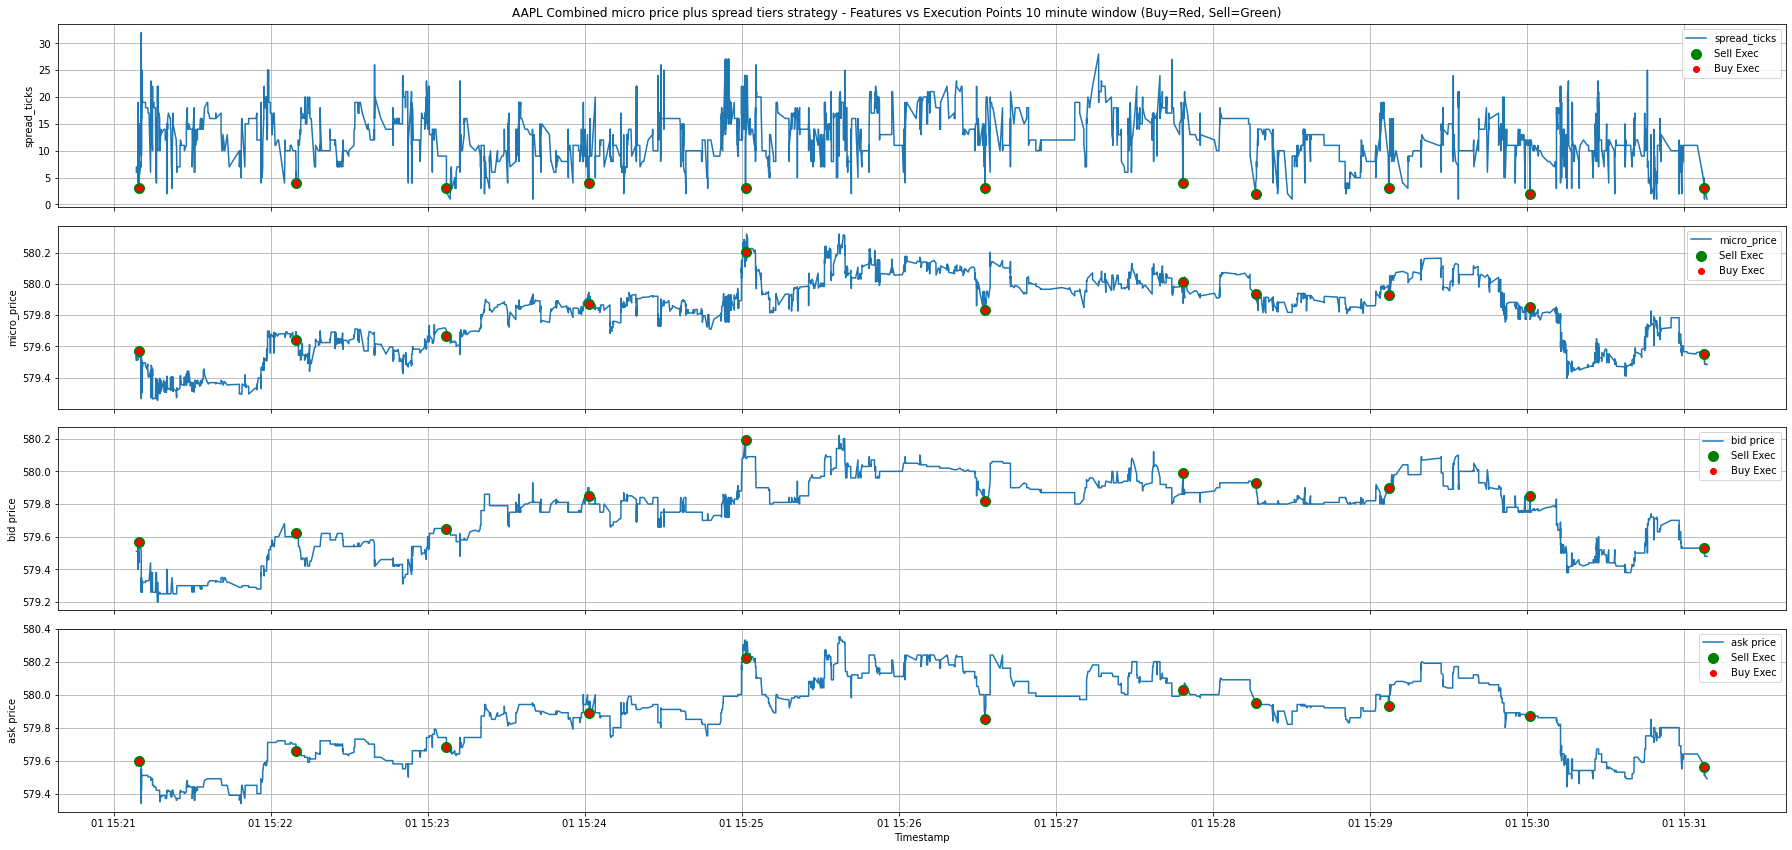

In [60]:
import matplotlib.pyplot as plt

ticker = 'AAPL'

df = dataframes[ticker]

ms, es = _minute_flags(df)
df['minute_start'], df['elapsed'] = ms, es

strategyToSymParamMap = {'AAPL': [exec_micro_price_spread_tiers_dual,(3, 4, 8, 9)] ,
                         'AMZN': [exec_micro_price_spread_tiers_dual,(2, 3, 4, 999)],
                         'GOOG': [exec_event_driven_dual,(0.3, 0.175, 0.0)],
                         'INTC': [exec_event_driven_dual,(0.7, 0.475, 0.0)],
                         'MSFT': [exec_event_driven_dual,(0.5, 0.325, 0.0)]}

algo = 'micro_price_plus_tiers'

algoName = {'micro_price_plus_tiers': 'Combined micro price plus spread tiers', 
            'event driven': 'event driven'}

paramsAlgo = {'micro_price_plus_tiers': (3, 4, 8, 9), 
            'event driven': (0.5, 0.325, 0.0)}

# Define time window
start_time = df.index.min()
end_time = start_time + pd.Timedelta(minutes=10)

# Filter the dataframe to this window
df_window = df.loc[(df.index >= start_time) & (df.index <= end_time)]
df2 = df_window.copy()

# Define features to plot
features = ['spread_ticks', 'micro_price', 'bid price', 'ask price']

# Get executions
outputDfs = strategyToSymParamMap[ticker][0](df2,params = strategyToSymParamMap[ticker][1])
buy_execs = outputDfs['buy']
sell_execs = outputDfs['sell']

# Plot each feature
n = len(features)
fig, axes = plt.subplots(n, 1, figsize=(25, 3*n), sharex=True)

if n == 1:
    axes = [axes]

for i, feature in enumerate(features):
    ax = axes[i]
    ax.plot(df2.index, df2[feature], label=feature, color='tab:blue')

    # Mark sell executions (green)
    if not sell_execs.empty:
        sell_times = sell_execs.index
        sell_vals = df2.loc[sell_times, feature]
        ax.scatter(sell_times, sell_vals, color='green', label='Sell Exec', zorder=5,s=100)

    # Mark buy executions (red)
    if not buy_execs.empty:
        buy_times = buy_execs.index
        buy_vals = df2.loc[buy_times, feature]
        ax.scatter(buy_times, buy_vals, color='red', label='Buy Exec', zorder=5,)



    ax.set_ylabel(feature)
    ax.legend()
    ax.grid(True)

plt.xlabel('Timestamp')
plt.suptitle(ticker + ' ' + algoName[algo]  + ' strategy - Features vs Execution Points 10 minute window (Buy=Red, Sell=Green)')
plt.tight_layout()
plt.show()

In [ ]:
## check trade distribution in the minute

side = 'buy'
trade_execution_times = strategies[algo](df, side=side).index

# Calculate the elapsed time in the minute for each trade
trade_execution_minutes = trade_execution_times.to_series().dt.second + trade_execution_times.to_series().dt.microsecond / 1e6

# Define the buckets (1-20, 20-40, 40-58, and 59-60)
buckets = ['1-20', '20-40', '40-58', '59-60']
bucket_edges = [0, 20, 40, 58, 60]

# Assign each trade to the appropriate bucket
trade_buckets = pd.cut(trade_execution_minutes, bins=bucket_edges, labels=buckets, right=True)

# Calculate the percentage of trades in each bucket
bucket_counts = trade_buckets.value_counts(normalize=True) * 100

# Plot the histogram
plt.figure(figsize=(8, 6))
ax = bucket_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add percentages on top of the bars
for i, count in enumerate(bucket_counts):
    ax.text(i, count + 1, f'{count:.2f}%', ha='center', va='bottom', fontsize=10)

plt.title('Before tuning ' + ticker + ' Buy Algorithm using '  + algo + ' Trade Execution Distribution by Time in Minute')
plt.xlabel('Time Bucket (Seconds)')
plt.ylabel('Percentage of Total Trades Executed (%)')
plt.xticks(rotation=0)
plt.show()

In [119]:
googlDf = dataframes['GOOG']

<AxesSubplot:xlabel='timestamp'>

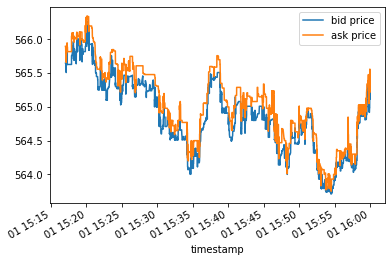

In [120]:
googlDf[['bid price','ask price']].plot()

In [102]:
googlDf.columns

Index(['time', 'bid price', 'bid volume', 'ask price', 'ask volume',
       'mid price', 'spread', 'spread_ticks', 'ofi', 'mid', 'mom', 'vol_t',
       'tau', 'ofi_z', 'mom_z', 'spread_ticks_z', 'tau_z', 'vol_t_z',
       'spread_z', 'micro_price', 'vol_imb', 'total_volume',
       'cum_price_volume', 'cum_volume', 'vwap', 'price_velocity',
       'price_lag_1', 'price_lag_2', 'price_lag_4', 'vol_imb_z',
       'total_volume_z', 'price_velocity_z', 'minute_start', 'elapsed'],
      dtype='object')

In [103]:
sellSide = googlDf[['minute_start','bid price']].groupby('minute_start').max()

In [104]:
buySide = googlDf[['minute_start','ask price']].groupby('minute_start').min()

In [105]:
mergedDf = pd.merge(sellSide,buySide,on=sellSide.index)

In [106]:
len(sellSide)==len(buySide)==len(mergedDf)

True

In [107]:
mergedDf['Spread'] = mergedDf['ask price'] - mergedDf['bid price']

In [108]:
mergedDf['Spread'].mean()

-0.01511627906976716